## Classical Dynamics Simulation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [7]:
@njit
def energy(s, w, h):
    return -w * s[0] * s[1] - h * np.sum(s)

@njit
def metropolis_update(s, w, h, beta, flip_two_spins=False):
    s_new = np.copy(s)
    
    if flip_two_spins:
        flip_indices = np.random.permutation(2)[:2]          # selects both spin indices to be flipped; upgradable to larger flips
    else:
        flip_indices = np.array([np.random.randint(2)])      # selects a singe spin index to be flipped
    
    s_new[flip_indices] *= -1
    delta_E = energy(s_new, w, h) - energy(s, w, h)
    
    if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
        s = s_new
    
    return s

@njit
def simulate_dynamics(w, h, beta, steps, flip_two_spins=False):
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(2)], dtype=np.int64)
    trajectory = np.empty((steps, 2), dtype=np.int64)
    
    for t in range(steps):
        s = metropolis_update(s, w, h, beta, flip_two_spins)
        trajectory[t] = s
    
    return trajectory

In [17]:
def system_state(s):
    if s[0] == 1 and s[1] == 1:
        state = 0

    if s[0] == 1 and s[1] == -1:
        state = 1

    if s[0] == -1 and s[1] == 1:
        state = 2

    if s[0] == -1 and s[1] == -1:
        state = 3
    return state

def plot_combined_dynamics(w, h, beta, steps, flip_two_spins=False):
    trajectory = simulate_dynamics(w, h, beta, steps, flip_two_spins)
    
    spin_product = trajectory[:, 0] * trajectory[:, 1]
    states = np.array([system_state(s) for s in trajectory])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    ax1.plot(states, label='System state', color ='MediumSeaGreen')
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('System state')
    ax1.set_yticks([0, 1, 2, 3])
    ax1.legend()

    ax2.plot(trajectory[:, 0], label='s1', color='FireBrick')
    ax2.plot(trajectory[:, 1] - 3, label='s2', color='DarkOrange')
    ax2.plot(spin_product - 6, label='s1*s2', color='Gold')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin values')
    ax2.set_yticks([-7, -5, -4,-2, -1, 1])
    ax2.set_yticklabels(['-1 ', '1 ', '-1', '1', '-1', '1'])
    ax2.legend()

    plt.show()

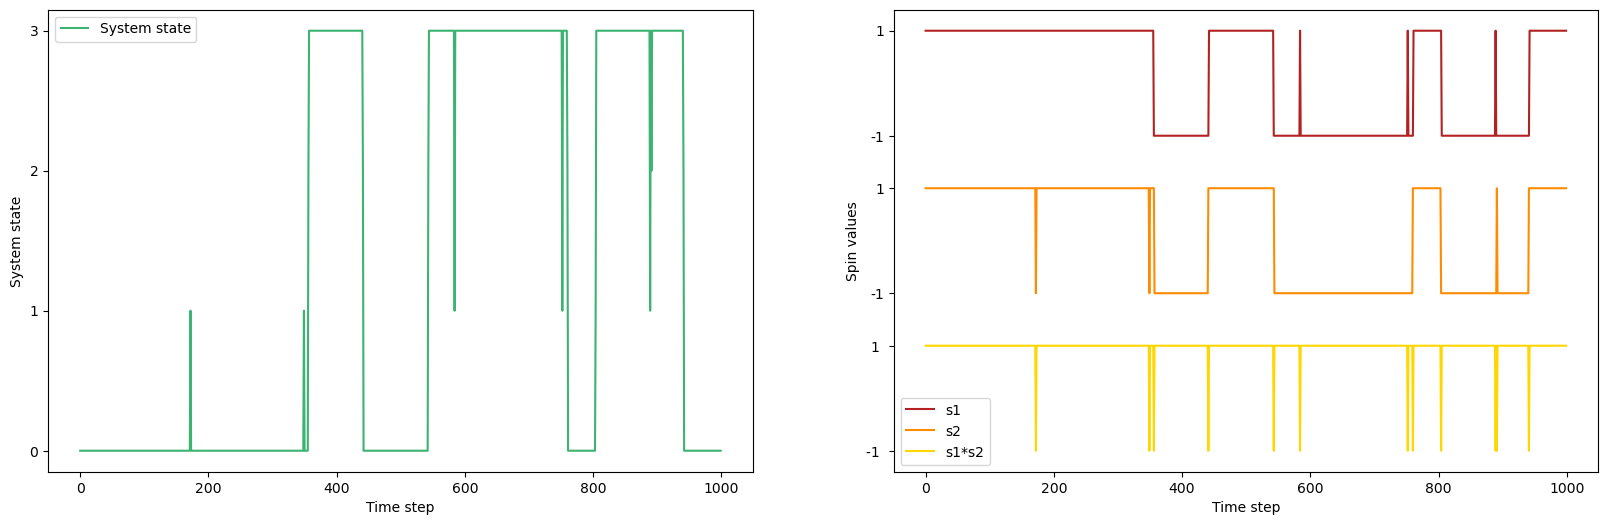

In [24]:
# PARAMETERS
w = 1.0         # Interaction strength
h = 0.0         # Self-interaction
beta = 2.3      # Inverse temperature
steps = 1000    # Number of time steps

plot_combined_dynamics(w, h, beta, steps, flip_two_spins=False)

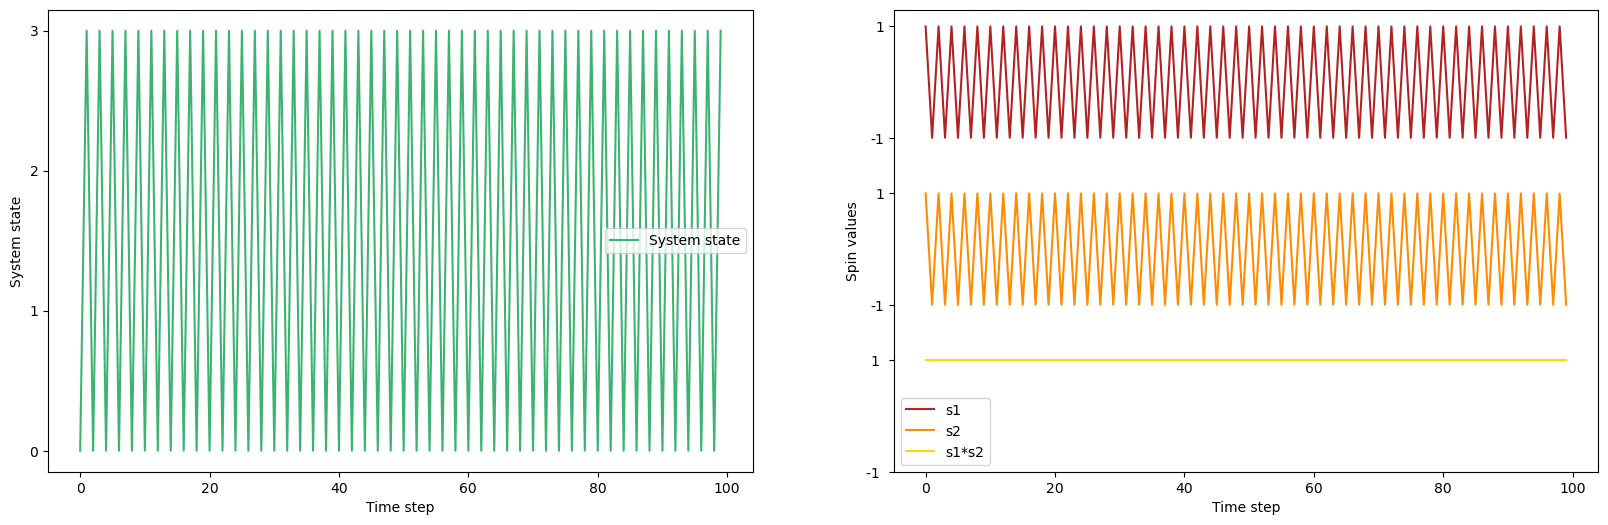

In [33]:
w = 0.1         # Interaction strength
h = 0.0         # Self-interaction
beta = 0.001      # Inverse temperature
steps = 100    # Number of time steps

plot_combined_dynamics(w, h, beta, steps, flip_two_spins=True)